In [21]:
import sys
sys.path.append("../../")
sys.path.append("../")

import copy

import paradime.routines
import paradime.utils
import torch
import torchvision

# from openTSNE import TSNE as OpenTSNE
# from sklearn.manifold import TSNE as ScikitTSNE
# from sklearn.manifold import trustworthiness

mnist = torchvision.datasets.MNIST(
    '../../data',
    train=True,
    download=True,
)
mnist_data = mnist.data.reshape(-1, 28*28) / 255.
num_items = 5000

In [68]:
dr = paradime.routines.ParametricTSNE(
    in_dim=28*28,
    hidden_dims=[1024, 512, 256, 128],
    perplexity=100,
    epochs=40,
    use_cuda=True,
    verbose=True,
)
dr.losses["exag"] = paradime.loss.RelationLoss(
    loss_function=paradime.loss.kullback_leibler_div,
    global_relation_key="exag",
)
non_exag = copy.deepcopy(dr.global_relations["rel"])
non_exag.transform.append(paradime.transforms.Functional(lambda x: 20*x))
dr.global_relations["exag"] = non_exag
dr.training_phases[1].epochs = 500
dr.training_phases[1].learning_rate = 0.001
dr.training_phases[1].batch_size = 256
dr.training_phases = [
    dr.training_phases[0],
    paradime.dr.TrainingPhase(
        name='exag',
        epochs=250,
        batch_size=256,
        batches_per_epoch=-1,
        sampling='standard',
        loss_keys=['exag'],
        loss_weights=[1.0],
        optimizer=torch.optim.Adam,
        learning_rate=0.001,
        report_interval=5,
    ),
    dr.training_phases[1],
]
dr.training_phases[1]._determine_loss(dr.losses)

In [69]:
dr.train(mnist_data[:num_items])

2023-03-17 17:03:55,982: Initializing training dataset.
2023-03-17 17:03:55,983: Computing derived data entry 'pca'.
2023-03-17 17:03:56,049: Adding entry 'pca' to dataset.
2023-03-17 17:03:56,049: Computing global relations 'rel'.
2023-03-17 17:03:56,050: Indexing nearest neighbors.
2023-03-17 17:03:58,943: Calculating probabilities.
2023-03-17 17:03:59,313: Computing global relations 'exag'.
2023-03-17 17:03:59,314: Indexing nearest neighbors.
2023-03-17 17:04:02,987: Calculating probabilities.
2023-03-17 17:04:03,370: Beginning training phase 'pca_init'.
2023-03-17 17:04:03,668: Loss after epoch 0: 3206.4048092365265
2023-03-17 17:04:04,008: Loss after epoch 5: 28.019762992858887
2023-03-17 17:04:04,282: Beginning training phase 'exag'.
2023-03-17 17:04:04,683: Loss after epoch 0: 0.2708031767979264
2023-03-17 17:04:06,688: Loss after epoch 5: 0.19602861069142818
2023-03-17 17:04:08,661: Loss after epoch 10: 0.1718711364082992
2023-03-17 17:04:10,666: Loss after epoch 15: 0.15767370

In [70]:
result = dr.apply(mnist_data[:num_items]).numpy()

<AxesSubplot:>

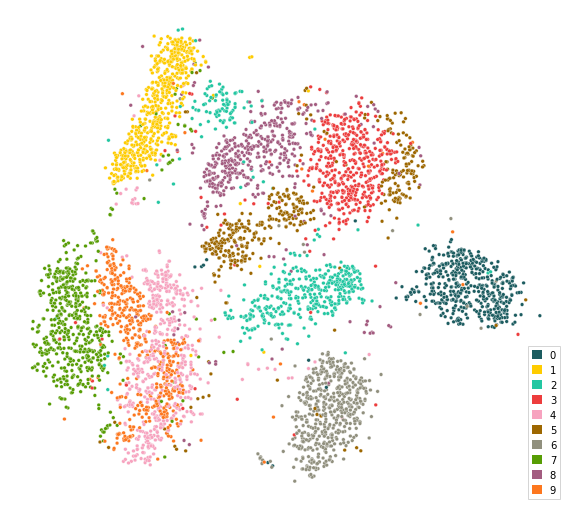

In [71]:
paradime.utils.plotting.scatterplot(result, labels=mnist.targets[:num_items])

<AxesSubplot:>

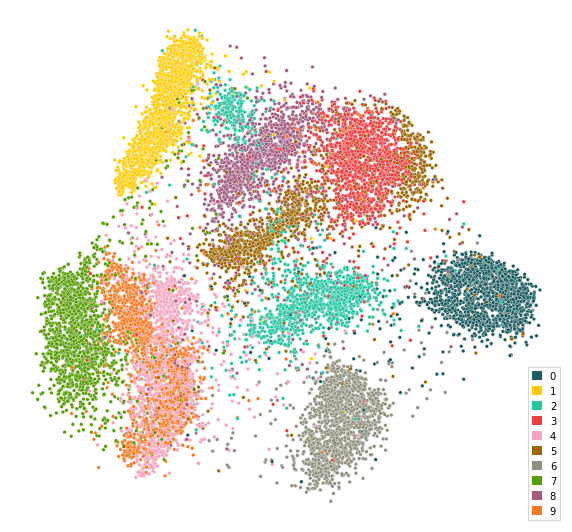

In [74]:
paradime.utils.plotting.scatterplot(dr.apply(mnist_data[num_items:num_items+15000]).numpy(), labels=mnist.targets[num_items:num_items+15000])

In [12]:
trustworthiness(
    mnist_data[:num_items].numpy(),
    tsne["sklearn"],
    n_neighbors=5,
)

0.985505032051282

In [13]:
trustworthiness(
    mnist_data[:num_items].numpy(),
    tsne["paradime"],
    n_neighbors=5,
)

0.9281994631410256

In [14]:
trustworthiness(
    mnist_data[:num_items].numpy(),
    tsne["open"],
    n_neighbors=5,
)

0.9826397435897436

<AxesSubplot:>

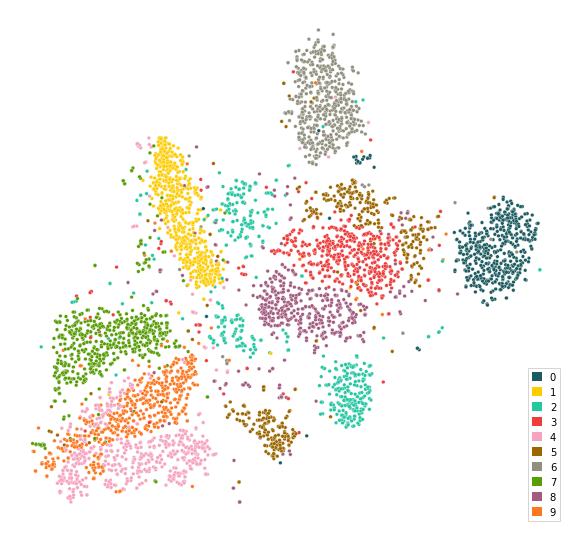

In [17]:
paradime.utils.plotting.scatterplot(tsne["open"], labels=mnist.targets[:num_items])

<AxesSubplot:>

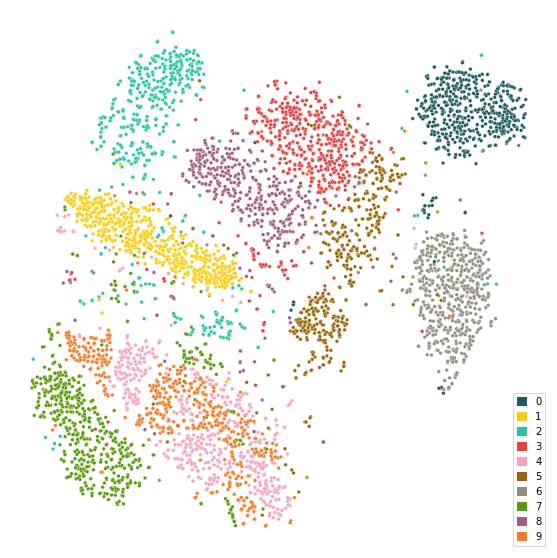

In [18]:
paradime.utils.plotting.scatterplot(tsne["sklearn"], labels=mnist.targets[:num_items])

<AxesSubplot:>

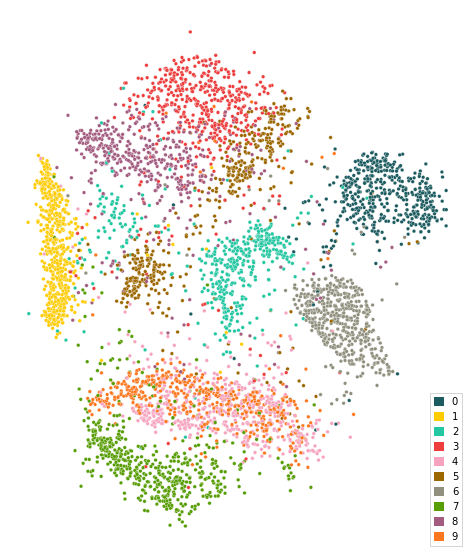

In [19]:
paradime.utils.plotting.scatterplot(tsne["paradime"], labels=mnist.targets[:num_items])

In [27]:
p = paradime.relations.PDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=100,
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
).compute_relations(mnist_data[:num_items])

In [31]:
q = {}

for k in tsne:
    q[k] = paradime.relations.PDist(
        transform=[
            paradime.transforms.StudentTTransform(
                alpha=1.0,
            ),
            paradime.transforms.Normalize(),
            paradime.transforms.ToSquareTensor(),
        ]
    ).compute_relations(tsne[k]).data


In [36]:
paradime.loss.kullback_leibler_div(
    p.data, q["open"]
) * num_items

tensor(0.9549, dtype=torch.float64)

In [37]:
paradime.loss.kullback_leibler_div(
    p.data, q["sklearn"]
) * num_items

tensor(0.9004, dtype=torch.float64)

In [38]:
paradime.loss.kullback_leibler_div(
    p.data, q["paradime"]
) * num_items

tensor(1.2604, dtype=torch.float64)

In [54]:
tsne_global_rel = paradime.relations.PDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=100, bracket=[0.001, 1000]
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
    ]
)

tsne_batch_rel = paradime.relations.DifferentiablePDist(
    transform=[
        paradime.transforms.StudentTTransform(alpha=1.0),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
)

pca = dr.dataset.data["pca"]

tsne_init = paradime.dr.TrainingPhase(
    name="pca_init",
    loss=paradime.loss.PositionLoss(position_key="pca"),
    batch_size=500,
    epochs=10,
    learning_rate=0.01,
)

tsne_main = paradime.dr.TrainingPhase(
    name="embedding",
    loss=paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div
    ),
    batch_size=500,
    epochs=40,
    learning_rate=0.01,
    report_interval=5,
)

pd_tsne = paradime.dr.ParametricDR(
    global_relations=tsne_global_rel,
    batch_relations=tsne_batch_rel,
    in_dim=28*28,
    out_dim=2,
    hidden_dims=[100,50],
    dataset=mnist_data[:num_items],
    use_cuda=True,
    verbose=True,
)
pd_tsne.add_to_dataset({"pca": pca})
pd_tsne.add_training_phase(tsne_init)
pd_tsne.add_training_phase(tsne_main)

2022-09-12 14:14:36,783: Registering dataset.
2022-09-12 14:14:36,797: Adding entry 'pca' to dataset.


In [55]:
pd_tsne.train()

2022-09-12 14:14:40,087: Computing global relations 'rel'.
2022-09-12 14:14:40,088: Calculating pairwise distances.
2022-09-12 14:14:51,287: Calculating probabilities.
2022-09-12 14:14:57,706: Beginning training phase 'pca_init'.
2022-09-12 14:14:57,826: Loss after epoch 0: 20.309013307094574
2022-09-12 14:14:58,187: Loss after epoch 5: 0.17209964711219072
2022-09-12 14:14:58,728: Beginning training phase 'embedding'.
2022-09-12 14:15:07,459: Loss after epoch 0: 0.049269783663074954
2022-09-12 14:15:50,735: Loss after epoch 5: 0.039009597912144055
2022-09-12 14:16:35,850: Loss after epoch 10: 0.03595826214247164
2022-09-12 14:17:20,787: Loss after epoch 15: 0.03460618999324702
2022-09-12 14:18:04,897: Loss after epoch 20: 0.03286616997271041
2022-09-12 14:18:52,255: Loss after epoch 25: 0.032457397416037176
2022-09-12 14:19:45,369: Loss after epoch 30: 0.032334874604363066
2022-09-12 14:20:37,535: Loss after epoch 35: 0.030612460792545496


<AxesSubplot:>

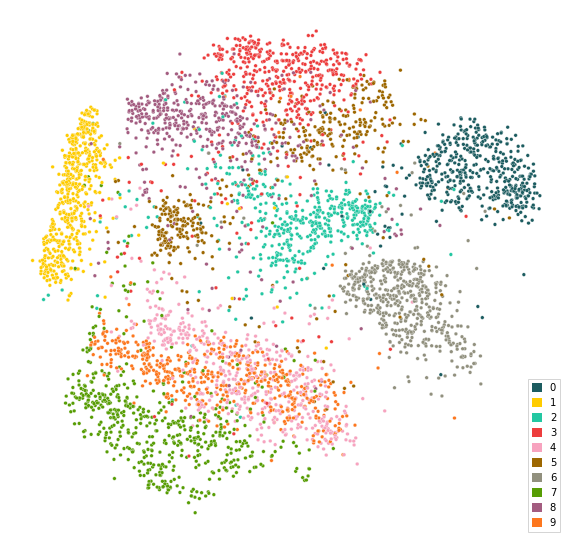

In [56]:
paradime.utils.plotting.scatterplot(pd_tsne.apply(mnist_data[:num_items]),labels=mnist.targets[:num_items])

In [57]:
q["paradime2"] = paradime.relations.PDist(
        transform=[
            paradime.transforms.StudentTTransform(
                alpha=1.0,
            ),
            paradime.transforms.Normalize(),
            paradime.transforms.ToSquareTensor(),
        ]
    ).compute_relations(pd_tsne.apply(mnist_data[:num_items])).data


In [59]:
from umap import ParametricUMAP